# TODO: 
- Tutte le task: fare train con 30 seeds (?) e 20 epoche (?) e poi fare commenti risultati
- Set del seed da ricontrollare
- Task 3: ripartizione dei mixed (prendere pochi supevised fissi e cambiare ratio di unsupervised) -> poi chiedere a tutor
- Task 3: rapporti alpha e beta per mixed da capire anche in base al punto precedente
- Task 4: gamma per ora 1.0 ma da fare un po' di esperimenti / tuning -> chiedere ai tutor
- Task 4: fare solo con 100% unsupervised? o provare con tutti i ratio della task 2? -> chiedere ai tutor
- guardare risultati rul e confrontare i risultati della task 2 e 4 sulle stesse macchine
- Task 5: aggiungere lagrangiano a modello Task 4 o 2? 
- Task 5: capire se peso dinamico va dato solo a cst o anche a mse e se va bene dare a cst solo peso dinamico o se ha senso fare somma di beta e lagr_multiplier -> chiedere a tutor
- Task 5: fare solo con 100% unsupervised? o provare con tutti i ratio della task 2? -> chiedere a i tutor 

- PW ?

In [228]:
# ============================================================
# Notebook setup
# ============================================================

%reload_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cst
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import tensorflow as tf
import random
#from tensorflow_probability import distributions
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras import backend as k

stop = 1400



## Data Loading and Preparation

### Data loading

In [229]:
# Load data
data_folder = '/app/data'
data = cst.load_cmapss_data(data_folder)
# Identify input columns
dt_in = list(data.columns[3:-1])

### Data inspection


- *src* is the train surce 
- *machine* is the number associated to a single machine
- *p* are the controlled parameters
- *s* are the sensors
- *rul* is the remaining useful life, namely the label 

In [230]:
data.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


Example of machine 1: the rul value goes from 191 to 0 decreasing monotonically

In [231]:
#print the data with 'machine' = 1
data[data['machine'] == 1].head(len(data[data['machine'] == 1]))

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD001,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,train_FD001,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,train_FD001,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,train_FD001,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,train_FD001,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,train_FD001,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,...,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588,4
188,train_FD001,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,...,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127,3
189,train_FD001,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,...,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675,2
190,train_FD001,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,...,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,1


We will plot a histogram showing the distribution of max rul values for each machine

<Axes: >

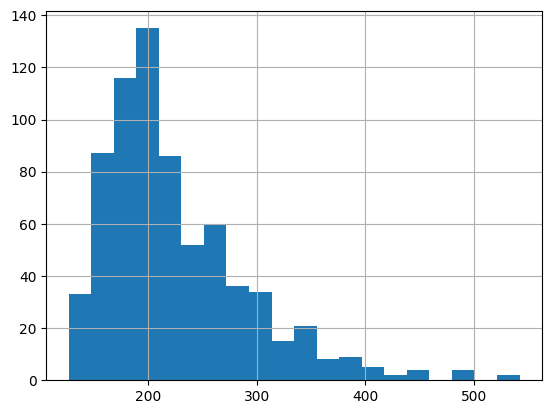

In [232]:
#define a histogram with value of rul for each machine where cycle=1 and src='FD001'
data[data['cycle'] == 1].groupby(['machine']).max()['rul'].hist(bins=20)


In [233]:
#standardize data
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()

In [234]:
data_by_src = cst.split_by_field(data_sv, field='src')

We inspect data by plotting heatmaps. We consider only data conatined in train_FD004, which has 6 operating conditions and 2 fault modes

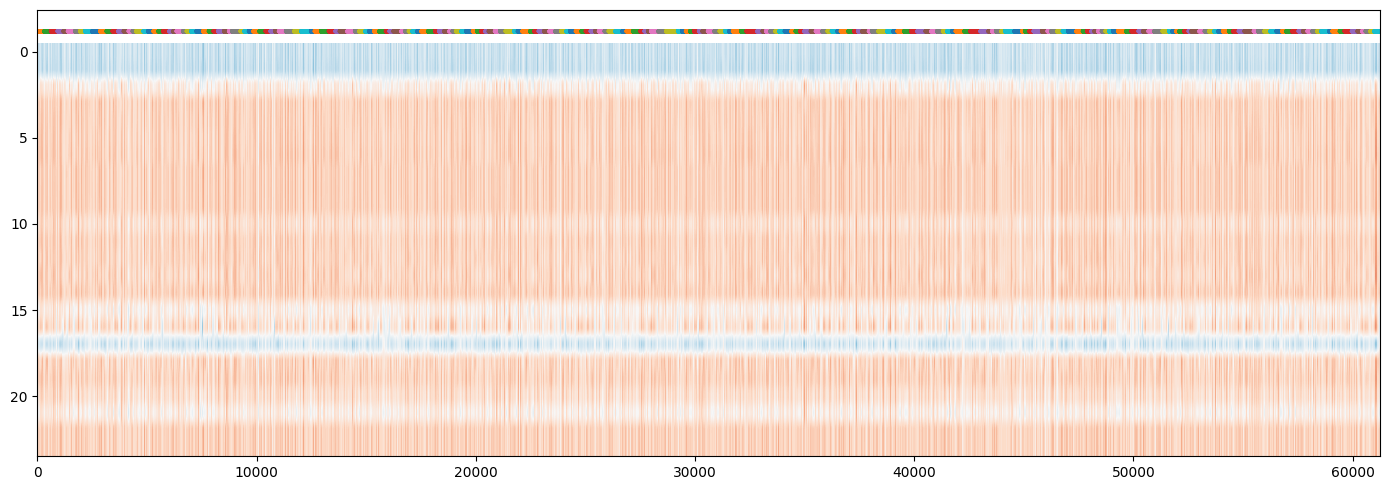

In [235]:
data_sv = data_by_src["train_FD004"]
cst.plot_dataframe(data_sv[dt_in], labels=data_sv['machine'], figsize=figsize)

There is a high varibaility in the plotted series, which is the result of multiple operating conditions

We will then inspect in detail a column providing information on a given sensor, to see if there is any claer trend in the data.

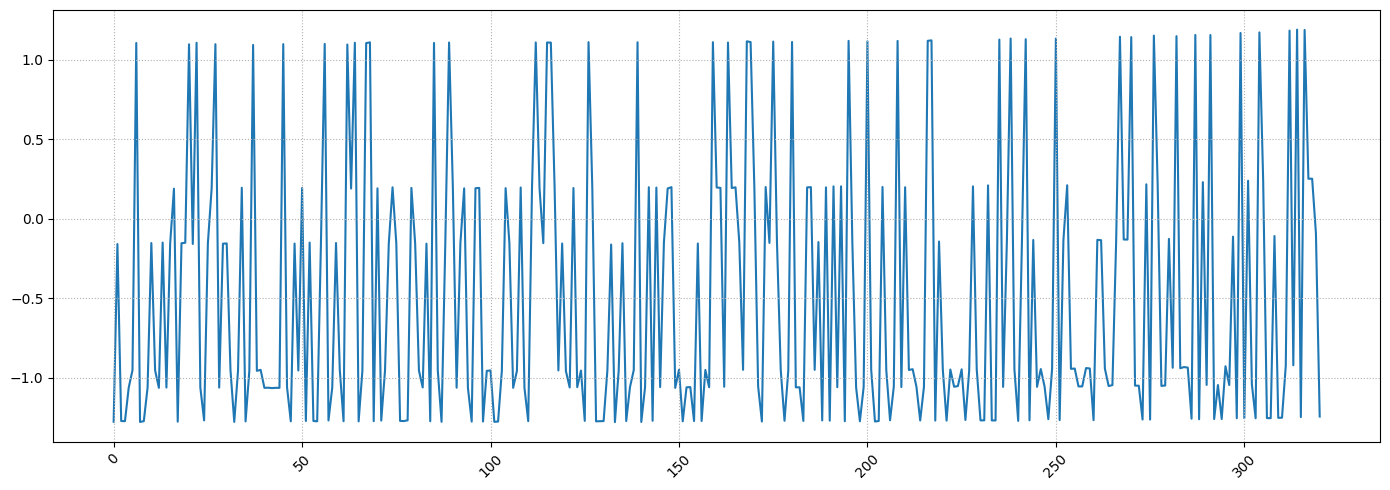

In [236]:
tmp = data_sv[data_sv['machine'] == data_sv['machine'].iloc[0]]
cst.plot_series(tmp['s7'], figsize=figsize)

There is a weak trend tied to component wear, and it is mainly covered by wide oscillations. 

In [237]:
#we use just dataset 4
dt = data_by_src["train_FD004"]

In [238]:
dt.head()

,src,machine,cycle,p1,p2,p3,s1,s2,s3,s4,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,train_FD004,461,1,1.500057,1.168664,0.345954,-1.342550,-1.122474,-1.045952,-1.086033,...,0.344929,-0.175148,0.370889,-1.037783,-0.989600,-0.433322,0.345954,-1.310594,-1.311278,320
1,train_FD004,461,2,0.168806,0.788709,0.345954,0.175840,0.205021,0.089480,-0.172094,...,0.342590,-0.531124,0.181688,-1.037783,0.009709,0.352571,0.345954,-0.134518,-0.129792,319
2,train_FD004,461,3,1.499991,1.171110,0.345954,-1.342550,-1.139659,-1.048575,-1.055806,...,0.344749,-0.276979,0.460301,-1.037783,-1.021836,-0.433322,0.345954,-1.322569,-1.303537,318
3,train_FD004,461,4,1.499761,1.168664,0.345954,-1.342550,-1.145544,-1.064484,-1.048616,...,0.345198,-0.160016,0.375413,-1.037783,-1.054071,-0.433322,0.345954,-1.317437,-1.304065,317
4,train_FD004,461,5,0.471584,0.572641,-2.890543,-0.765963,-1.442165,-1.792301,-1.668131,...,-2.892626,-2.767824,2.370806,-1.037783,-1.795494,-2.517341,-2.890543,-1.018927,-0.982214,316


## Project

**We will run multiple experiments on our data to analyse the effect of domain knowledge injection via multiple approaches.**

- In the first 3 tasks we will experiment with different ratios and combinations of supervised and unsupervised data.
- In task 4 we will use a static regularizer to inject domain knowledge (RUL>0). 
- In task 5 we will use a lagrangian approach to dynamically maximize the weight of the regularizer.

### Task 1: train the model with only supervised data. We will experiment with different ratios of supervised data. 


In general, we expect that using higher ratios of supervised data will ensure better performances. However, if the model is too simple, it may incur in overfitting. 
- We expect that all the models trained with supervised data are the ones performing better. 
- Moreover, we expect that they learn the decreasing trend and also to predict the failure in an accurate way.
- We foresee that using 100% of supervised data will ensure the best results, however we do not expect that the differences in performances won't be as significant as those in the models with both supervised and unsupervised data. 

#### 1.1 100% of supervised data used for training

In [239]:
trs, ts = cst.split_machines(dt, 0.75, 0)

Num. machines: 186 (supervised), 63 (test)


In [240]:
trs_s, ts_s, trmaxrul = cst.standardize(trs, ts, dt_in)

We train the model with different seeds

In [248]:
pred = []
for i in range(30):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn = cst.CstRULRegressor(input_shape=len(dt_in), alpha=1, beta=0, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trs_s, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
    nn.compile(optimizer='Adam', run_eagerly=False)
    history = nn.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)
    pred.append(nn.predict(ts_s[dt_in]).ravel())

Epoch 1/20
1521/1521 [==============================] - 4s 3ms/step - loss: 0.0198 - mse: 0.0198 - cst: 0.0068
Epoch 2/20
1521/1521 [==============================] - 4s 3ms/step - loss: 0.0150 - mse: 0.0150 - cst: 0.0038
Epoch 3/20
1521/1521 [==============================] - 4s 3ms/step - loss: 0.0144 - mse: 0.0144 - cst: 0.0036
Epoch 4/20
1521/1521 [==============================] - 4s 3ms/step - loss: 0.0143 - mse: 0.0143 - cst: 0.0037
Epoch 5/20
1521/1521 [==============================] - 4s 3ms/step - loss: 0.0142 - mse: 0.0142 - cst: 0.0037
Epoch 6/20
1521/1521 [==============================] - 4s 3ms/step - loss: 0.0136 - mse: 0.0136 - cst: 0.0032
Epoch 7/20
1521/1521 [==============================] - 4s 3ms/step - loss: 0.0136 - mse: 0.0136 - cst: 0.0031
Epoch 8/20
1521/1521 [==============================] - 4s 3ms/step - loss: 0.0134 - mse: 0.0134 - cst: 0.0030
Epoch 9/20
1521/1521 [==============================] - 4s 3ms/step - loss: 0.0132 - mse: 0.0132 - cst: 0.0028
E

Evaluation on the test set

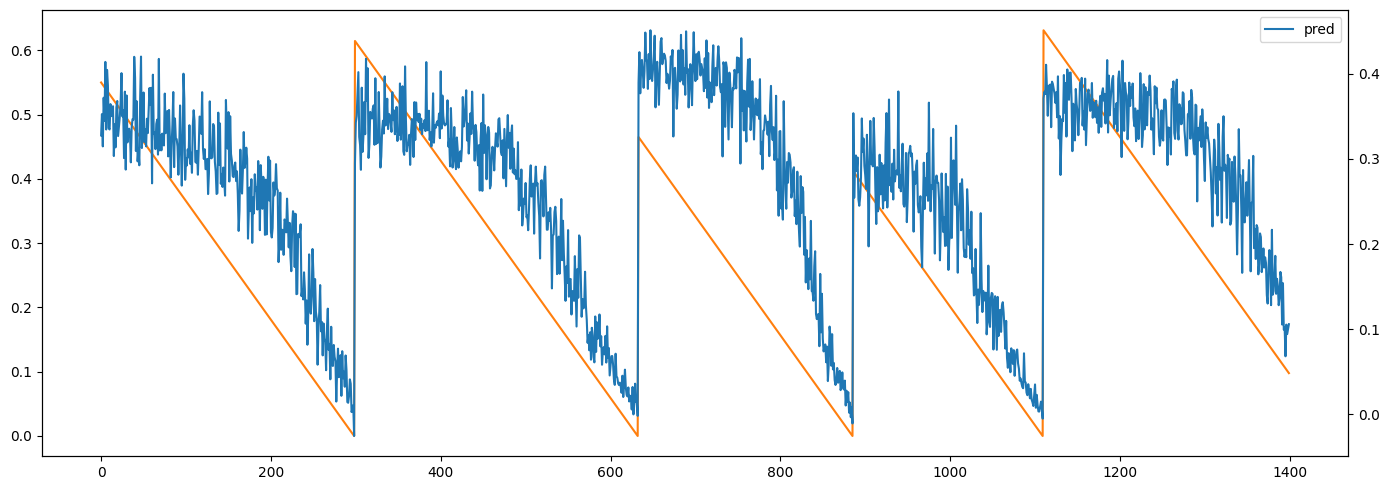

In [249]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [250]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0121
Deviazione standard della MSE: 0.0006


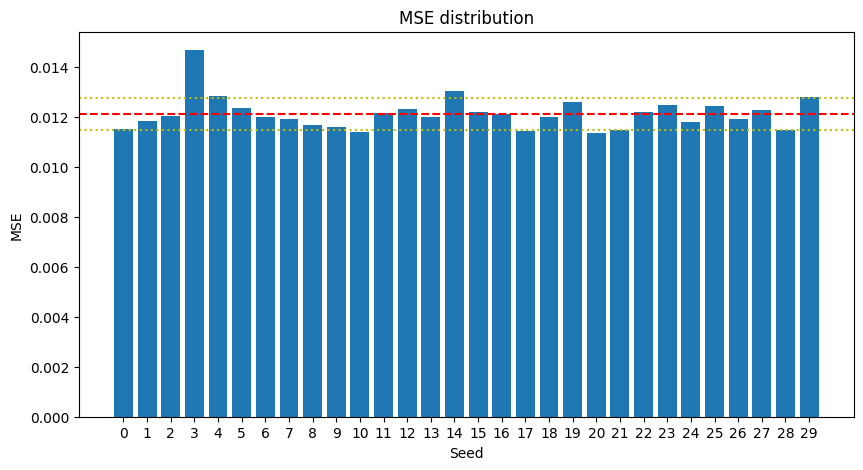

In [251]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

#### 1.2 75% of supervised data used for training

In [252]:
trs_2 = cst.split_data(ts, trs=trs, trs_ratio=0.75)

Num. samples: 34038 (supervised), 15864 (test)


In [253]:
trs_s, ts_s, trmaxrul = cst.standardize(trs_2, ts, dt_in)

In [254]:
pred = []
for i in range(30):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn = cst.CstRULRegressor(input_shape=len(dt_in), alpha=1, beta=0, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trs_s, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
    nn.compile(optimizer='Adam', run_eagerly=False)
    history = nn.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)
    pred.append(nn.predict(ts_s[dt_in]).ravel())

Epoch 1/20
1138/1138 [==============================] - 3s 2ms/step - loss: 0.0225 - mse: 0.0225 - cst: 0.0079
Epoch 2/20
1138/1138 [==============================] - 3s 2ms/step - loss: 0.0164 - mse: 0.0164 - cst: 0.0040
Epoch 3/20
1138/1138 [==============================] - 3s 2ms/step - loss: 0.0156 - mse: 0.0156 - cst: 0.0039
Epoch 4/20
1138/1138 [==============================] - 3s 2ms/step - loss: 0.0151 - mse: 0.0151 - cst: 0.0034
Epoch 5/20
1138/1138 [==============================] - 3s 2ms/step - loss: 0.0151 - mse: 0.0151 - cst: 0.0037
Epoch 6/20
1138/1138 [==============================] - 3s 2ms/step - loss: 0.0146 - mse: 0.0146 - cst: 0.0032
Epoch 7/20
1138/1138 [==============================] - 3s 2ms/step - loss: 0.0144 - mse: 0.0144 - cst: 0.0031
Epoch 8/20
1138/1138 [==============================] - 3s 2ms/step - loss: 0.0145 - mse: 0.0145 - cst: 0.0033
Epoch 9/20
1138/1138 [==============================] - 3s 2ms/step - loss: 0.0142 - mse: 0.0142 - cst: 0.0031
E

Evaluation on the test set 

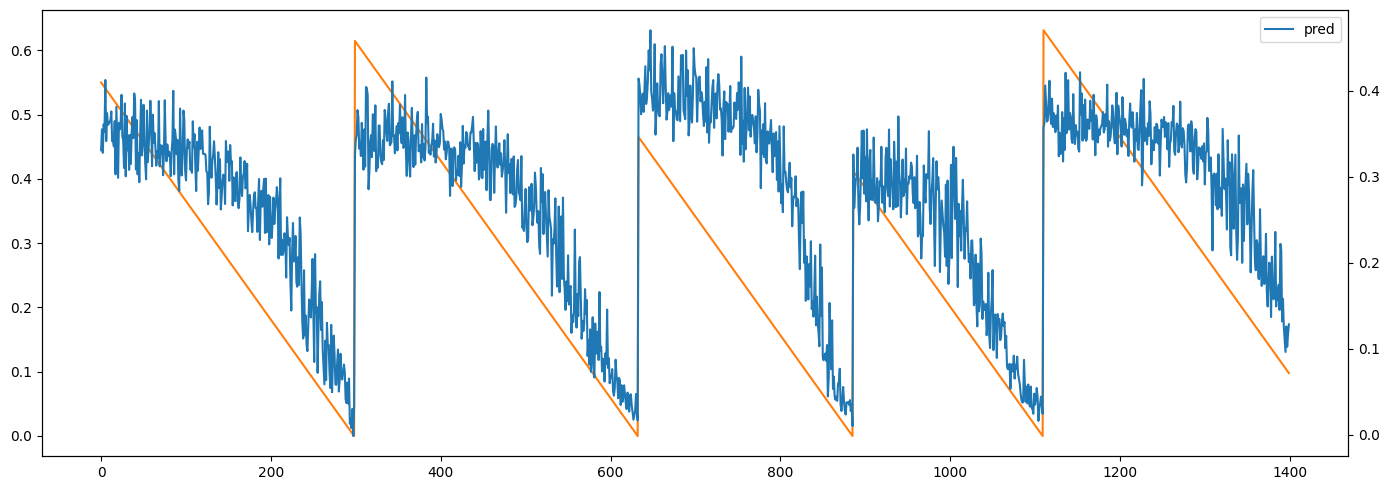

In [255]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [256]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0124
Deviazione standard della MSE: 0.0011


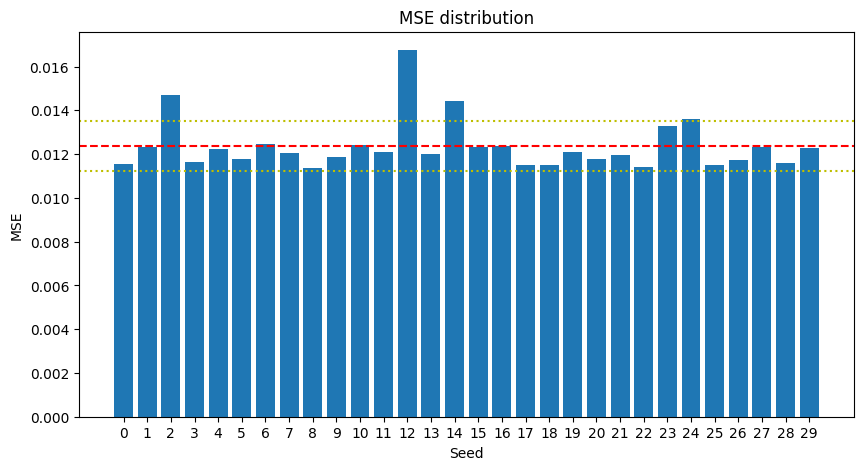

In [257]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

#### 1.3 50% of supervised data used for training

In [258]:
trs_3 = cst.split_data(ts, trs=trs, trs_ratio=0.50)

Num. samples: 22692 (supervised), 15864 (test)


In [259]:
trs_s, ts_s, trmaxrul = cst.standardize(trs_3, ts, dt_in)

In [260]:
pred = []
for i in range(30):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn = cst.CstRULRegressor(input_shape=len(dt_in), alpha=1, beta=0, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trs_s, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
    nn.compile(optimizer='Adam', run_eagerly=False)
    history = nn.fit(batch_gen, epochs=20, verbose=1, callbacks=cb)
    pred.append(nn.predict(ts_s[dt_in]).ravel())

Epoch 1/20
760/760 [==============================] - 2s 2ms/step - loss: 0.0233 - mse: 0.0233 - cst: 0.0088
Epoch 2/20
760/760 [==============================] - 2s 2ms/step - loss: 0.0161 - mse: 0.0161 - cst: 0.0042
Epoch 3/20
760/760 [==============================] - 2s 2ms/step - loss: 0.0150 - mse: 0.0150 - cst: 0.0038
Epoch 4/20
760/760 [==============================] - 2s 2ms/step - loss: 0.0147 - mse: 0.0147 - cst: 0.0040
Epoch 5/20
760/760 [==============================] - 2s 2ms/step - loss: 0.0140 - mse: 0.0140 - cst: 0.0034
Epoch 6/20
760/760 [==============================] - 2s 2ms/step - loss: 0.0139 - mse: 0.0139 - cst: 0.0036
Epoch 7/20
760/760 [==============================] - 1s 2ms/step - loss: 0.0141 - mse: 0.0141 - cst: 0.0038
Epoch 8/20
760/760 [==============================] - 1s 2ms/step - loss: 0.0135 - mse: 0.0135 - cst: 0.0032
Epoch 9/20
760/760 [==============================] - 2s 2ms/step - loss: 0.0135 - mse: 0.0135 - cst: 0.0032
Epoch 10/20
760/760

Evaluation on the test set

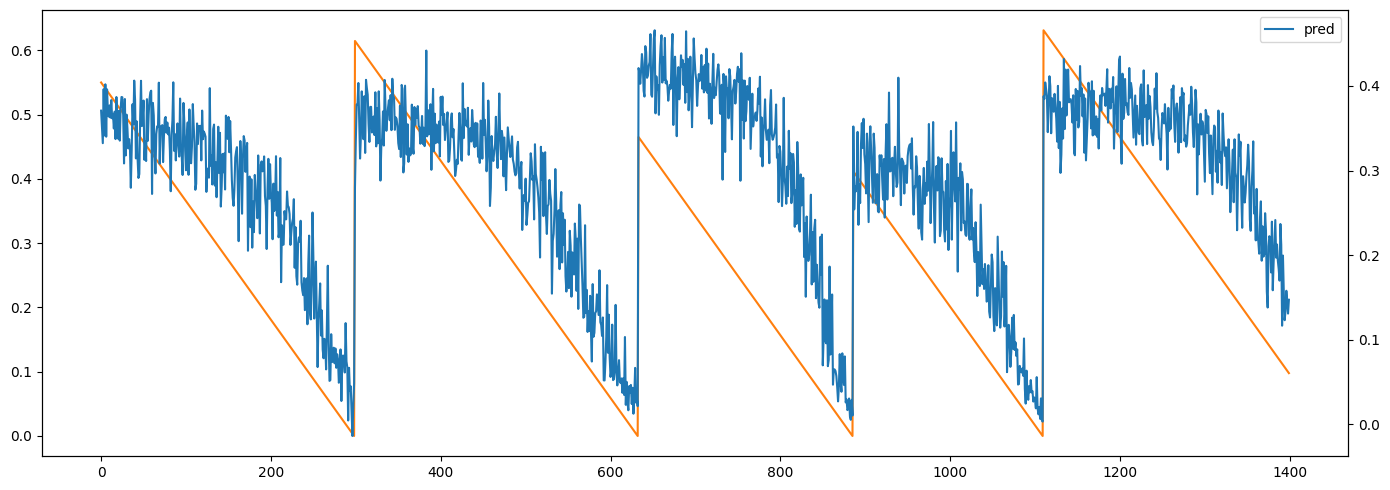

In [261]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [262]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0131
Deviazione standard della MSE: 0.0013


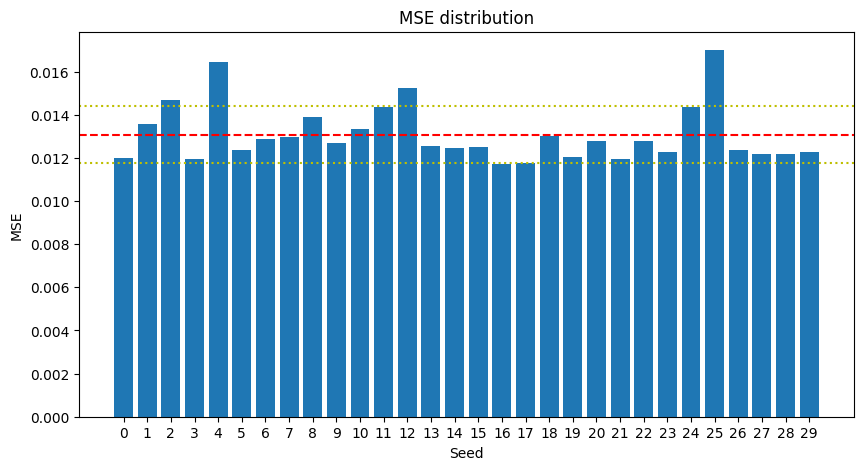

In [263]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

**Results**

### Task 2: train the model with only unsupervised data. We will experiment with different ratios of supervised data. 


While training the models only with unsupervised data, we do not have great expectations. Indeed, using only unsupervised data there is no way the model can learn to predict the RUL. However, we will see if it is possible for the regressor to learn the constraint which imposes that the RUL for a machine should decrease. In comparison with the full supervised models, we expect that unsupervised models won't be able to predict the initial RUL as accurately as the supervised models.
In general, we expect that the perormances will be worse with respect the superivised experiments.

In [136]:
tru, ts = cst.split_machines(dt, 0, 0.75)

Num. machines: 186 (unsupervised), 63 (test)


In [137]:
print(f'Num. samples: {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 45385 (unsupervised), 15864 (test)


#### 100% of unsupervised data

In [138]:
tru_s, ts_s, trmaxrul = cst.standardize(tru, ts, dt_in)

Removing RUL Values

**We start by preparing a bit more the unsupervised data**

* First, we _remove the end_ of the unsupervised data sequences
* This simulate the fact that the machines are still operating

In [139]:
tru_st = cst.remove_rul(tru_s)

In [81]:
pred = []
for i in range(3):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0034 - mse: 0.0000e+00 - cst: 0.0034
Epoch 2/5
1339/1339 [==============================] - 3s 2ms/step - loss: 4.7123e-04 - mse: 0.0000e+00 - cst: 4.7123e-04
Epoch 3/5
1339/1339 [==============================] - 3s 2ms/step - loss: 4.5285e-04 - mse: 0.0000e+00 - cst: 4.5285e-04
Epoch 4/5
1339/1339 [==============================] - 3s 2ms/step - loss: 4.4543e-04 - mse: 0.0000e+00 - cst: 4.4543e-04
Epoch 5/5
496/496 [==============================] - 0s 370us/step
Epoch 1/5
1339/1339 [==============================] - 4s 2ms/step - loss: 0.0010 - mse: 0.0000e+00 - cst: 0.0010
Epoch 2/5
1339/1339 [==============================] - 4s 3ms/step - loss: 4.2461e-04 - mse: 0.0000e+00 - cst: 4.2461e-04
Epoch 3/5
1339/1339 [==============================] - 3s 3ms/step - loss: 4.1862e-04 - mse: 0.0000e+00 - cst: 4.1862e-04
Epoch 4/5
1339/1339 [==============================] - 3s 3ms/step - loss: 4.0908e-04 - mse: 0.

Evaluation on the test set

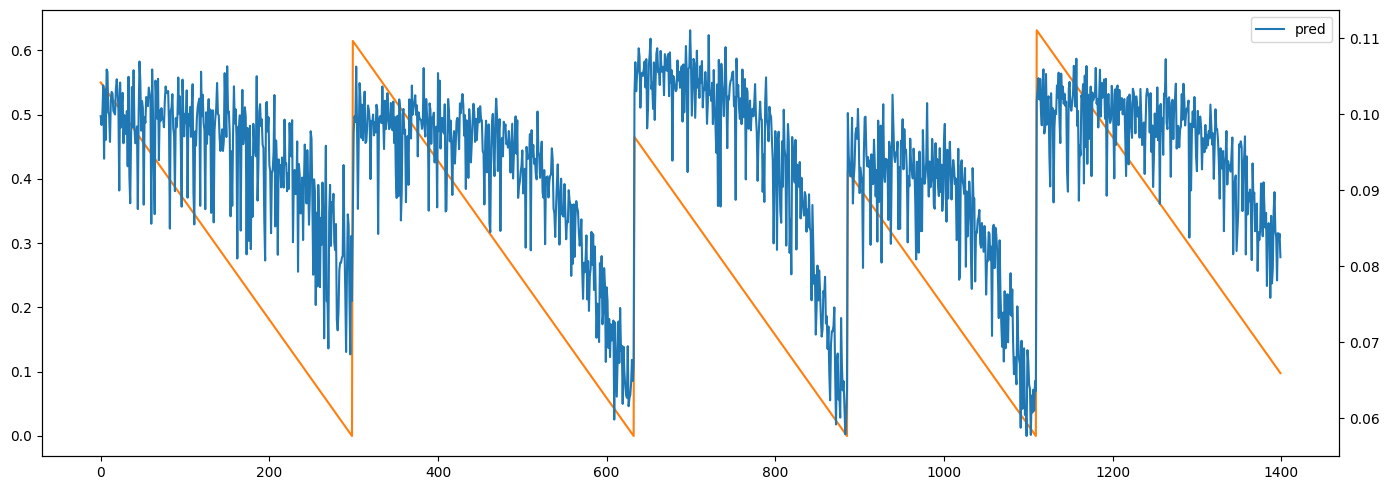

In [82]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [83]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0722
Deviazione standard della MSE: 0.0150


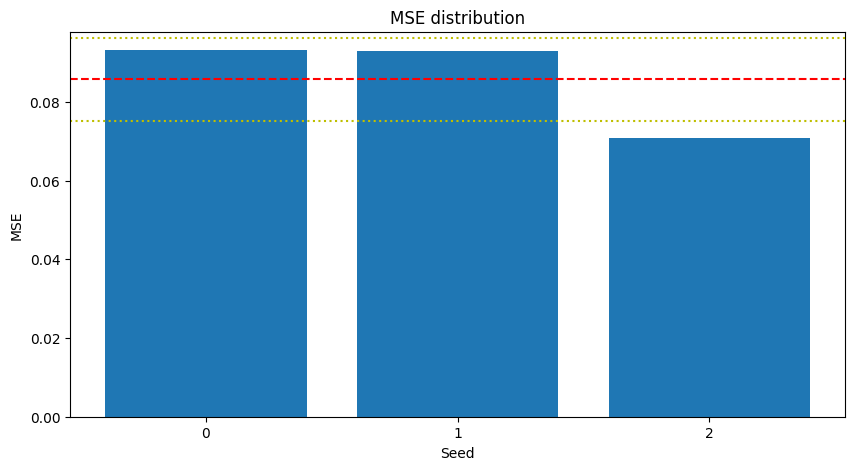

In [27]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

#### 75% of unsupervised data

In [70]:
tru_2 = cst.split_data(ts, tru=tru, tru_ratio=0.75)

Num. samples: 34038 (unsupervised), 15864 (test)


In [71]:
tru_s, ts_s, trmaxrul = cst.standardize(tru_2, ts, dt_in)

In [72]:
tru_st = cst.remove_rul(tru_s)

In [77]:
pred = []
for i in range(3):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
1001/1001 [==============================] - 3s 2ms/step - loss: 0.0028 - mse: 0.0000e+00 - cst: 0.0028
Epoch 2/5
1001/1001 [==============================] - 3s 3ms/step - loss: 5.1408e-04 - mse: 0.0000e+00 - cst: 5.1408e-04
Epoch 3/5
1001/1001 [==============================] - 3s 3ms/step - loss: 4.8653e-04 - mse: 0.0000e+00 - cst: 4.8653e-04
Epoch 4/5
1001/1001 [==============================] - 3s 3ms/step - loss: 4.7500e-04 - mse: 0.0000e+00 - cst: 4.7500e-04
Epoch 5/5
496/496 [==============================] - 0s 478us/step
Epoch 1/5
1001/1001 [==============================] - 3s 3ms/step - loss: 9.1514e-04 - mse: 0.0000e+00 - cst: 9.1514e-04
Epoch 2/5
1001/1001 [==============================] - 3s 3ms/step - loss: 4.7960e-04 - mse: 0.0000e+00 - cst: 4.7960e-04
Epoch 3/5
1001/1001 [==============================] - 3s 3ms/step - loss: 4.5369e-04 - mse: 0.0000e+00 - cst: 4.5369e-04
Epoch 4/5
1001/1001 [==============================] - 3s 3ms/step - loss: 4.2330e-04 -

Evaluation on the test set

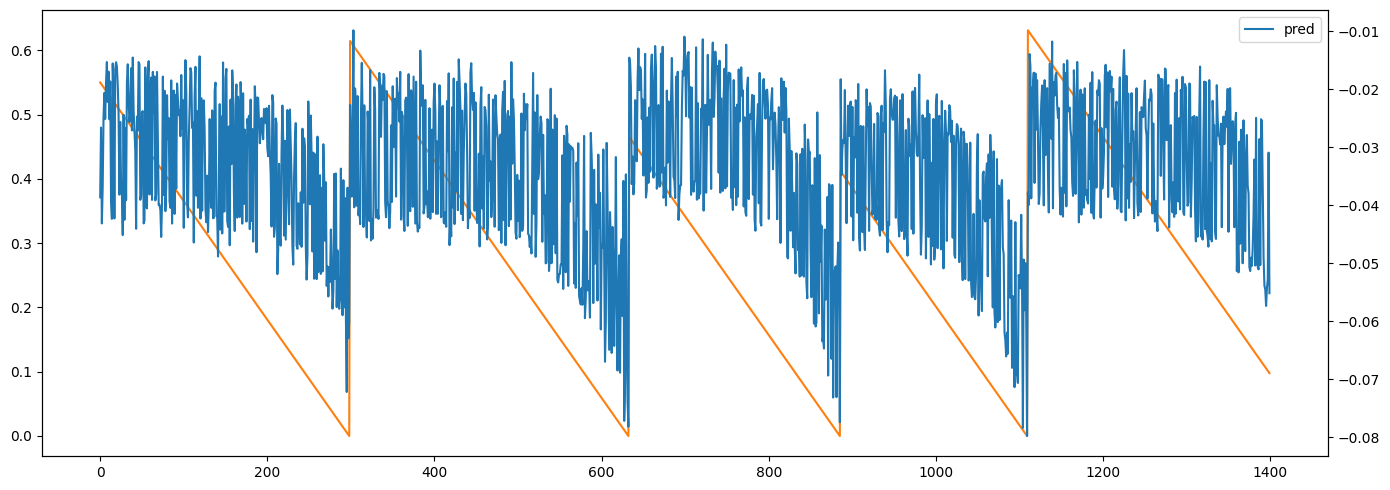

In [78]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [79]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0968
Deviazione standard della MSE: 0.0145


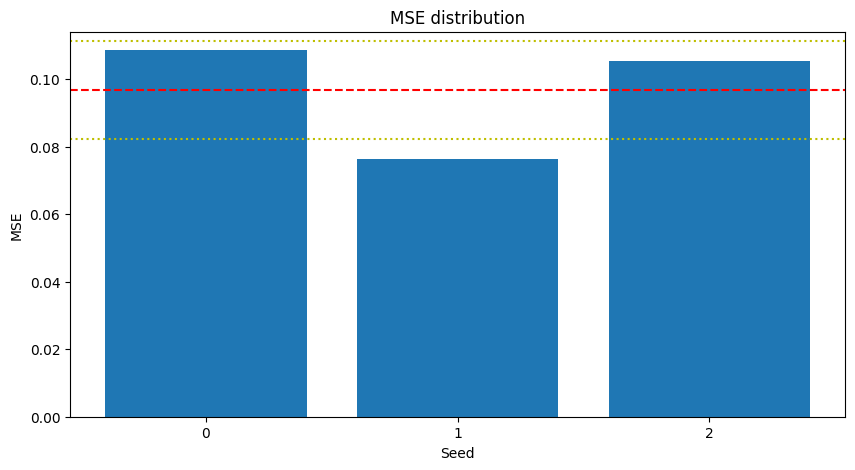

In [80]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

#### 50% of unsupervised

In [81]:
tru_3 = cst.split_data(ts, tru=tru, tru_ratio=0.50)

Num. samples: 22692 (unsupervised), 15864 (test)


In [82]:
tru_s, ts_s, trmaxrul = cst.standardize(tru_3, ts, dt_in)

In [83]:
tru_st = cst.remove_rul(tru_s)

In [84]:
pred = []
for i in range(3):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
670/670 [==============================] - 2s 2ms/step - loss: 0.0069 - mse: 0.0000e+00 - cst: 0.0069
Epoch 2/5
670/670 [==============================] - 1s 2ms/step - loss: 5.0147e-04 - mse: 0.0000e+00 - cst: 5.0147e-04
Epoch 3/5
670/670 [==============================] - 1s 2ms/step - loss: 4.6723e-04 - mse: 0.0000e+00 - cst: 4.6723e-04
Epoch 4/5
670/670 [==============================] - 1s 2ms/step - loss: 4.5410e-04 - mse: 0.0000e+00 - cst: 4.5410e-04
Epoch 5/5
496/496 [==============================] - 0s 384us/step
Epoch 1/5
670/670 [==============================] - 2s 2ms/step - loss: 0.0040 - mse: 0.0000e+00 - cst: 0.0040
Epoch 2/5
670/670 [==============================] - 1s 2ms/step - loss: 4.7565e-04 - mse: 0.0000e+00 - cst: 4.7565e-04
Epoch 3/5
670/670 [==============================] - 1s 2ms/step - loss: 4.5469e-04 - mse: 0.0000e+00 - cst: 4.5469e-04
Epoch 4/5
670/670 [==============================] - 1s 2ms/step - loss: 4.6573e-04 - mse: 0.0000e+00 - cst: 

Evaluation on the test set

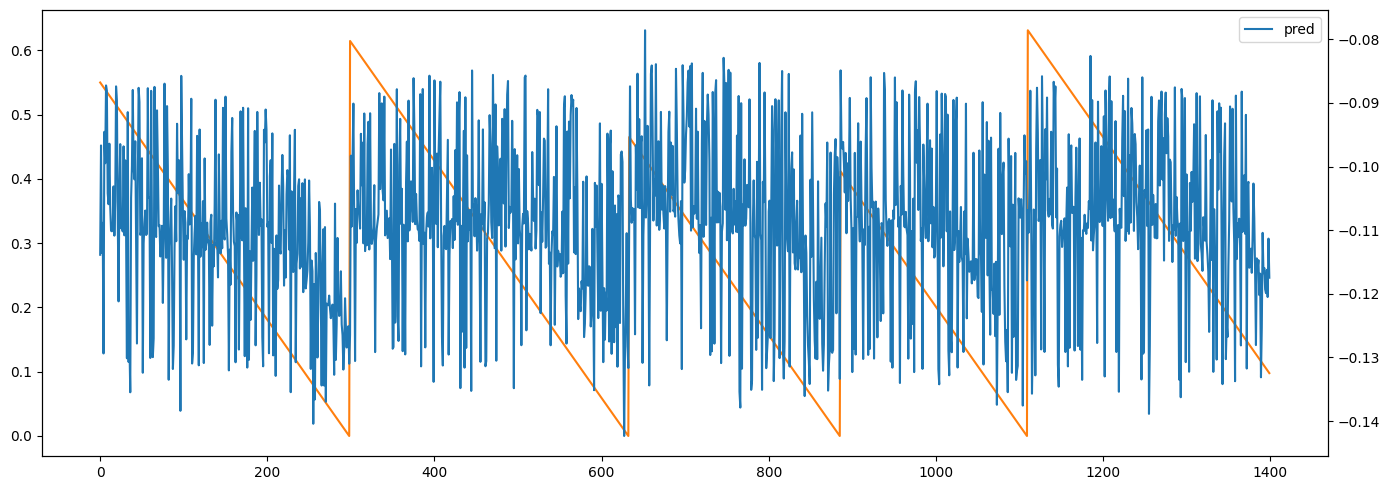

In [85]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [86]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.1123
Deviazione standard della MSE: 0.0416


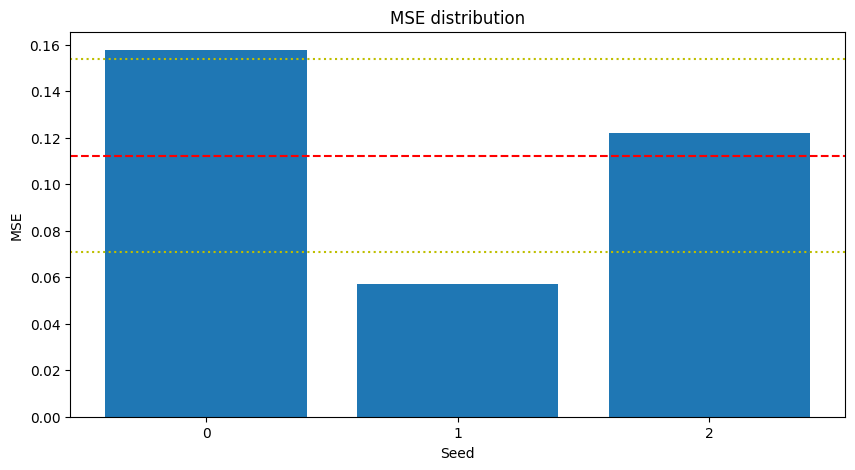

In [87]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

**results**
meglio del previsto

### Task 3: train the model with both supervised and unsupervised data. We will experiment with different ratios of unsupervised and supervised data. 


We expect that the performances of models trained with both supervised and unsupervied data will lay in between those of the models trained just with supervised data and the models trained with only unsupervised data, meaning that they will have better performances wrt the unsupervised models, but worse than those of supervised models. Moreover, changing the ratio will greatly influence the performances of the models. *scrivere per le combinazioni*
- a) increasing the number of supervised samples (25%, 50%, 100%), with fixed unsupervised samples, will lead to a more performing model
- b) increasing the number of unsupervised samples (25%, 50%, 100%), with fixed supervised samples, will lead to a less improvement in the performances with respect to a.




#### 3.1 Fixed number of unsupervised - decreasing number of supervised

In [84]:
tr, ts, trs, tru = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 124 (supervised), 62 (unsupervised), 63 (test)


##### 3.1.1 100% unsupervised, 100% supervised

In [85]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 30572 (supervised), 14813 (unsupervised), 15864 (test)


In [86]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [87]:
tru_st = cst.remove_rul(tru_s)

In [88]:
trsu_s = pd.concat((trs_s, tru_st))

In [96]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=1, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())
    

Epoch 1/5
1465/1465 [==============================] - 4s 3ms/step - loss: 0.0204 - mse: 0.0169 - cst: 0.0035
Epoch 2/5
1465/1465 [==============================] - 4s 3ms/step - loss: 0.0146 - mse: 0.0125 - cst: 0.0020
Epoch 3/5
1465/1465 [==============================] - 4s 3ms/step - loss: 0.0139 - mse: 0.0119 - cst: 0.0020
Epoch 4/5
1465/1465 [==============================] - 4s 3ms/step - loss: 0.0137 - mse: 0.0117 - cst: 0.0020
Epoch 5/5
496/496 [==============================] - 0s 376us/step
Epoch 1/5
1465/1465 [==============================] - 4s 3ms/step - loss: 0.0186 - mse: 0.0162 - cst: 0.0024
Epoch 2/5
1465/1465 [==============================] - 4s 3ms/step - loss: 0.0153 - mse: 0.0132 - cst: 0.0021
Epoch 3/5
1465/1465 [==============================] - 4s 3ms/step - loss: 0.0138 - mse: 0.0120 - cst: 0.0018
Epoch 4/5
1465/1465 [==============================] - 4s 3ms/step - loss: 0.0132 - mse: 0.0114 - cst: 0.0018
Epoch 5/5
496/496 [==============================] - 

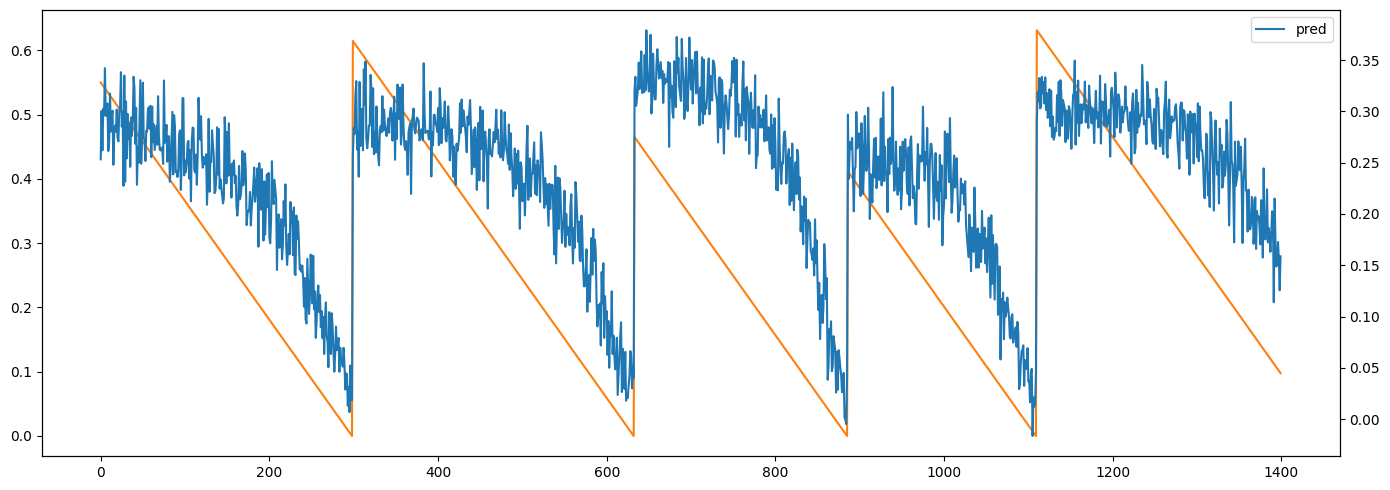

In [97]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [98]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0140
Deviazione standard della MSE: 0.0009


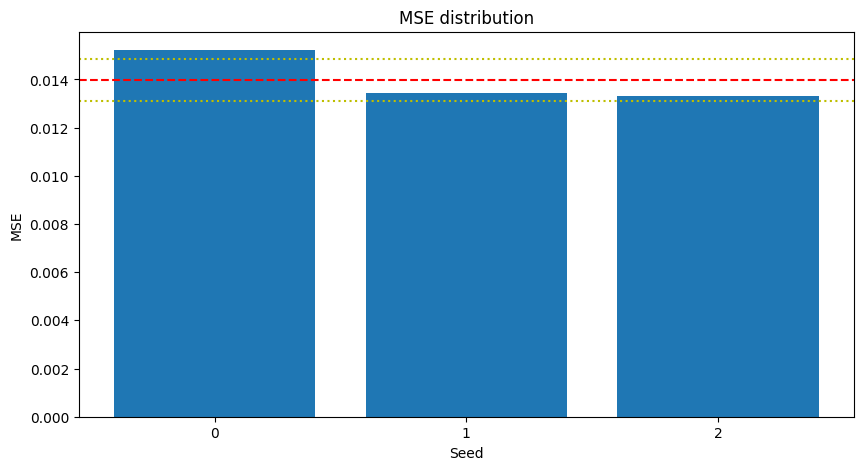

In [99]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

##### 3.1.2. 100% unsupervised, 50% supervised

In [100]:
ratio_sup = 0.50 # 50 % dei supervisionati
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 15286 (supervised), 14813 (unsupervised), 15864 (test)


In [101]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [102]:
tru_st = cst.remove_rul(tru_s)

In [103]:
trsu_s = pd.concat((trs_s, tru_st))

In [104]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=1, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
949/949 [==============================] - 3s 2ms/step - loss: 0.0185 - mse: 0.0142 - cst: 0.0043
Epoch 2/5
949/949 [==============================] - 2s 2ms/step - loss: 0.0127 - mse: 0.0110 - cst: 0.0017
Epoch 3/5
949/949 [==============================] - 2s 2ms/step - loss: 0.0116 - mse: 0.0098 - cst: 0.0019
Epoch 4/5
949/949 [==============================] - 2s 2ms/step - loss: 0.0111 - mse: 0.0094 - cst: 0.0017
Epoch 5/5
496/496 [==============================] - 0s 358us/step
Epoch 1/5
949/949 [==============================] - 2s 2ms/step - loss: 0.0172 - mse: 0.0141 - cst: 0.0031
Epoch 2/5
949/949 [==============================] - 2s 2ms/step - loss: 0.0131 - mse: 0.0113 - cst: 0.0018
Epoch 3/5
949/949 [==============================] - 2s 2ms/step - loss: 0.0120 - mse: 0.0103 - cst: 0.0018
Epoch 4/5
949/949 [==============================] - 2s 2ms/step - loss: 0.0114 - mse: 0.0096 - cst: 0.0018
Epoch 5/5
496/496 [==============================] - 0s 362us/step
Ep

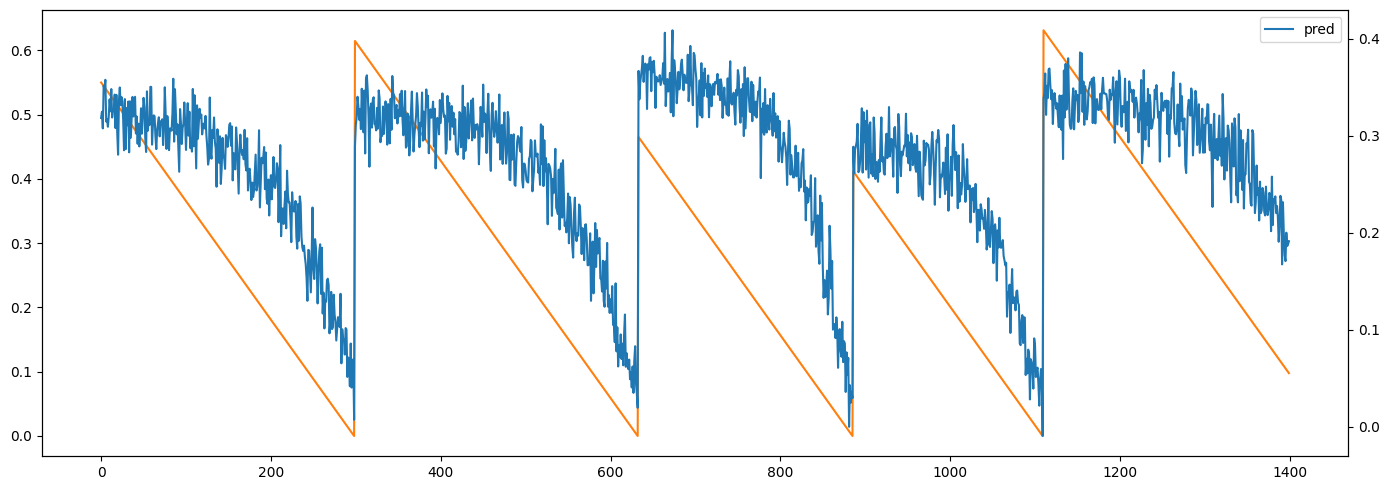

In [105]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [106]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0153
Deviazione standard della MSE: 0.0017


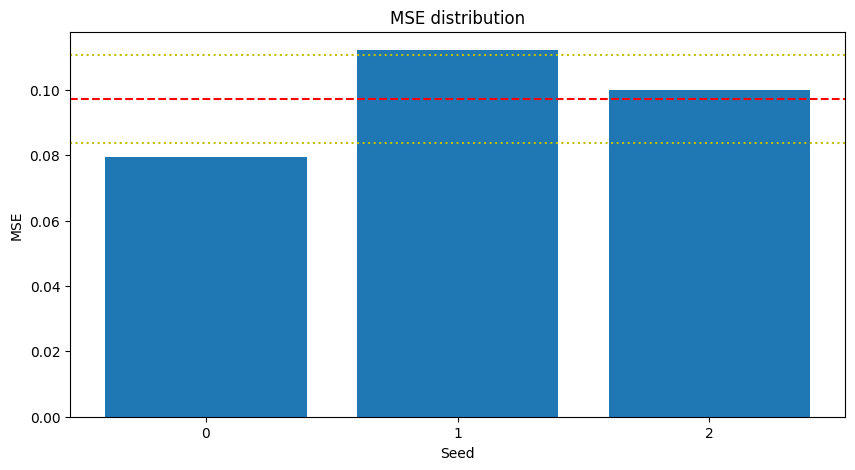

In [19]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

##### 3.1.3. 100% unsupervised, 25% supervised

In [107]:
ratio_sup = 0.25 # 20 % dei supervisionati
trs = trs[:int(len(trs) * ratio_sup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 3821 (supervised), 14813 (unsupervised), 15864 (test)


In [108]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [109]:
tru_st = cst.remove_rul(tru_s)

In [110]:
trsu_s = pd.concat((trs_s, tru_st))

In [111]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=1, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
567/567 [==============================] - 1s 2ms/step - loss: 0.0089 - mse: 0.0061 - cst: 0.0028
Epoch 2/5
567/567 [==============================] - 1s 2ms/step - loss: 0.0056 - mse: 0.0041 - cst: 0.0015
Epoch 3/5
567/567 [==============================] - 1s 2ms/step - loss: 0.0052 - mse: 0.0039 - cst: 0.0013
Epoch 4/5
567/567 [==============================] - 1s 2ms/step - loss: 0.0053 - mse: 0.0037 - cst: 0.0015
Epoch 5/5
496/496 [==============================] - 0s 361us/step
Epoch 1/5
567/567 [==============================] - 1s 2ms/step - loss: 0.0120 - mse: 0.0071 - cst: 0.0048
Epoch 2/5
567/567 [==============================] - 1s 2ms/step - loss: 0.0070 - mse: 0.0055 - cst: 0.0015
Epoch 3/5
567/567 [==============================] - 1s 2ms/step - loss: 0.0062 - mse: 0.0048 - cst: 0.0013
Epoch 4/5
567/567 [==============================] - 1s 2ms/step - loss: 0.0059 - mse: 0.0045 - cst: 0.0014
Epoch 5/5
496/496 [==============================] - 0s 372us/step
Ep

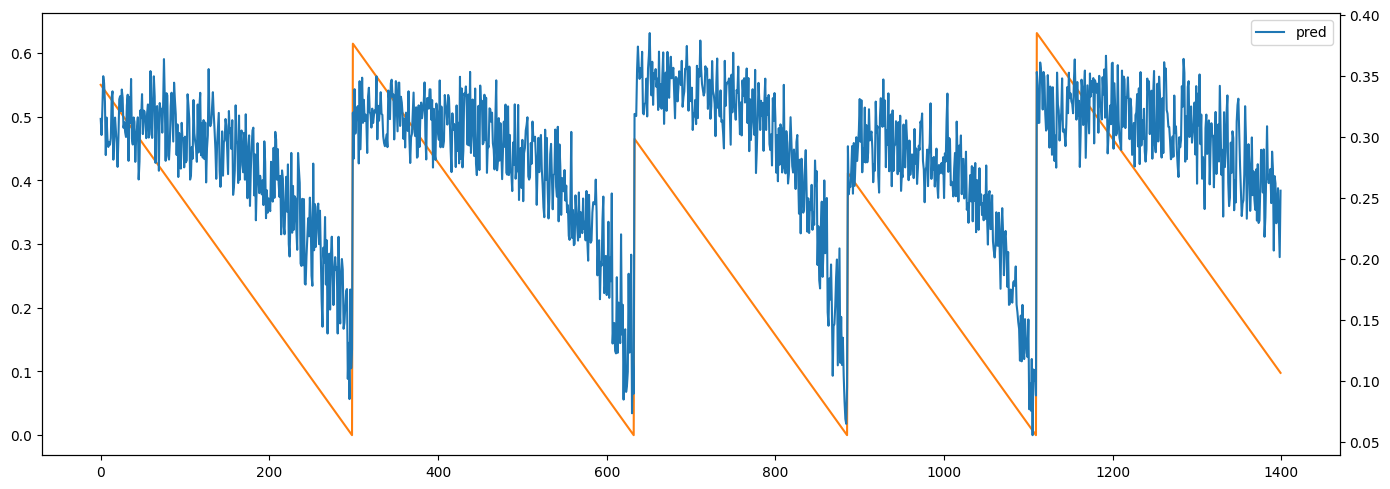

In [112]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [113]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0193
Deviazione standard della MSE: 0.0015


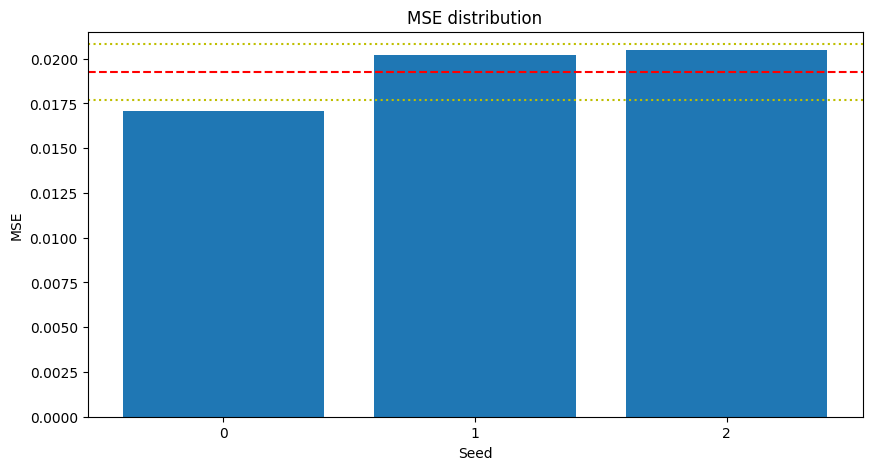

In [114]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

#### 3.2 Fixed number of supervised - decreasing number of unsupervised 

In [115]:
tr, ts, trs, tru = cst.split_machines(dt, 0.50, 0.75)

Num. machines: 124 (supervised), 62 (unsupervised), 63 (test)


##### 1. 100% unsupervised, 100% supervised  -> UGUALE A PRIMA , TOGLIERE

In [116]:
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 30572 (supervised), 14813 (unsupervised), 15864 (test)


In [ ]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [ ]:
tru_st = cst.remove_rul(tru_s)

/tmp/ipykernel_11/1631041332.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cutoff = int(np.random.randint(10, 50, 1))


In [ ]:
trsu_s = pd.concat((trs_s, tru_st))

In [ ]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())
    

Epoch 1/5
1465/1465 [==============================] - 4s 3ms/step - loss: 124.5045 - mse: 0.1617 - cst: 124.5045
Epoch 2/5
1465/1465 [==============================] - 4s 3ms/step - loss: 121.7646 - mse: 0.7725 - cst: 121.7646
Epoch 3/5
1465/1465 [==============================] - 4s 3ms/step - loss: 121.1747 - mse: 3.5487 - cst: 121.1747
Epoch 4/5
1465/1465 [==============================] - 4s 3ms/step - loss: 120.2364 - mse: 6.8375 - cst: 120.2364
Epoch 5/5
1465/1465 [==============================] - 4s 3ms/step - loss: 119.5118 - mse: 10.1947 - cst: 119.5118


43/43 [==============================] - 0s 479us/step


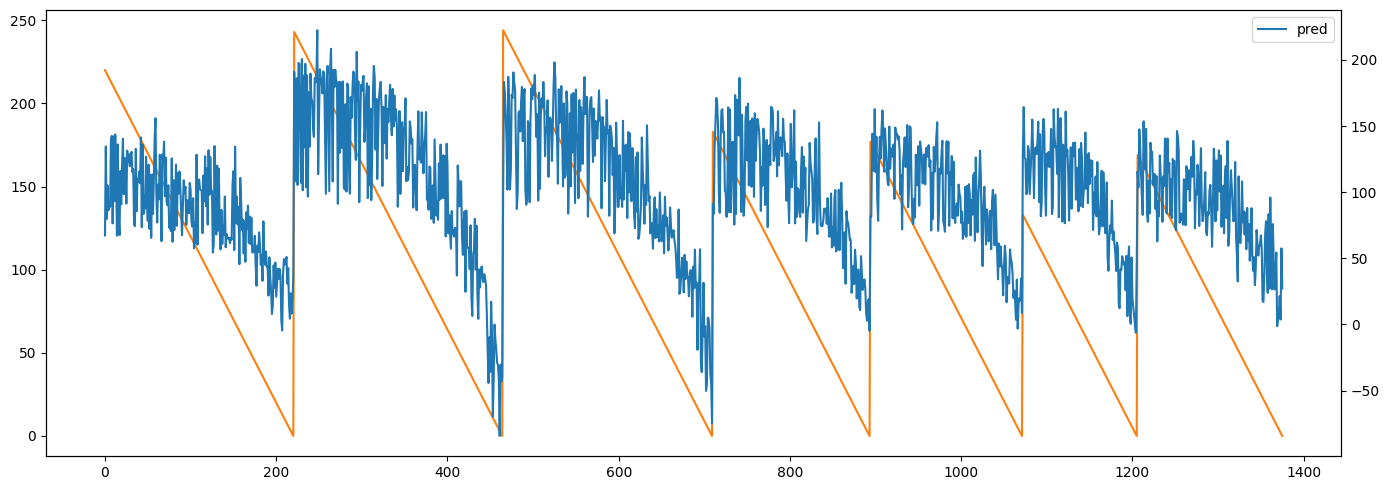

In [ ]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [ ]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

In [ ]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

##### 3.2.1 100% unsupervised, 50% supervised

In [117]:
ratio_unsup = 0.50 # 50% of unsupervised 
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 30572 (supervised), 7406 (unsupervised), 15864 (test)


In [118]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [119]:
tru_st = cst.remove_rul(tru_s)

In [120]:
trsu_s = pd.concat((trs_s, tru_st))

In [121]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=1, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
1243/1243 [==============================] - 3s 3ms/step - loss: 0.0224 - mse: 0.0189 - cst: 0.0035
Epoch 2/5
1243/1243 [==============================] - 3s 3ms/step - loss: 0.0168 - mse: 0.0145 - cst: 0.0023
Epoch 3/5
1243/1243 [==============================] - 3s 3ms/step - loss: 0.0161 - mse: 0.0138 - cst: 0.0022
Epoch 4/5
1243/1243 [==============================] - 3s 3ms/step - loss: 0.0154 - mse: 0.0134 - cst: 0.0020
Epoch 5/5
496/496 [==============================] - 1s 365us/step
Epoch 1/5
1243/1243 [==============================] - 3s 2ms/step - loss: 0.0252 - mse: 0.0219 - cst: 0.0033
Epoch 2/5
1243/1243 [==============================] - 3s 2ms/step - loss: 0.0169 - mse: 0.0147 - cst: 0.0022
Epoch 3/5
1243/1243 [==============================] - 3s 2ms/step - loss: 0.0156 - mse: 0.0135 - cst: 0.0020
Epoch 4/5
1243/1243 [==============================] - 3s 2ms/step - loss: 0.0152 - mse: 0.0131 - cst: 0.0020
Epoch 5/5
496/496 [==============================] - 

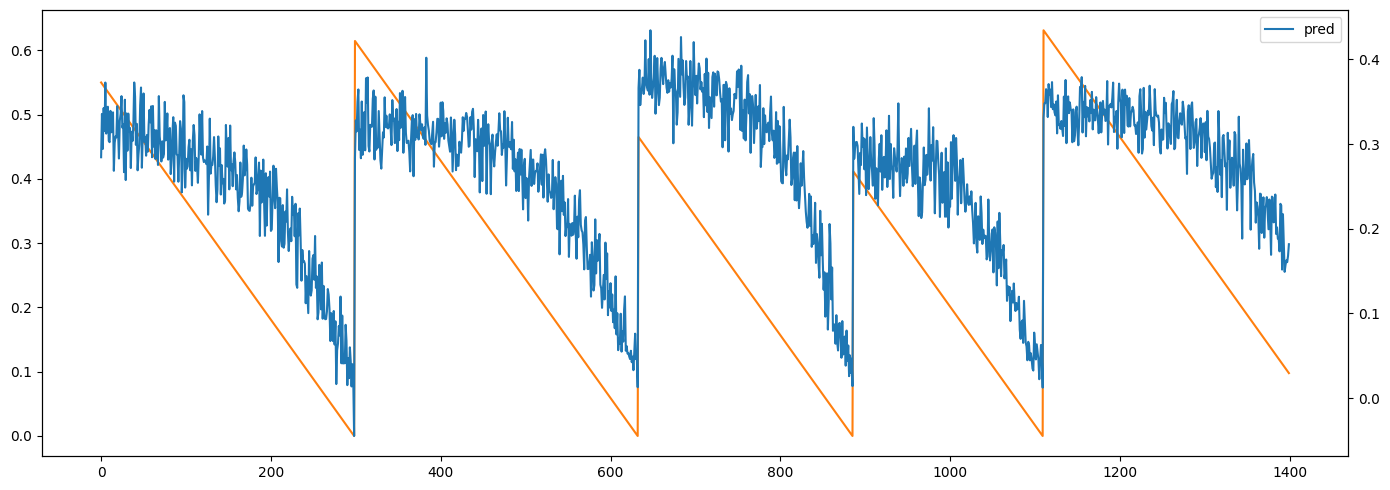

In [122]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [123]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0139
Deviazione standard della MSE: 0.0006


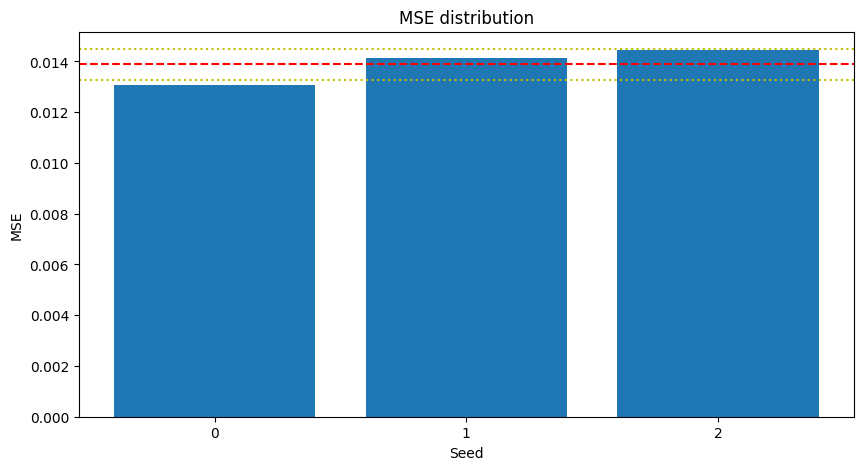

In [124]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

##### 3.2.2. 100% supervised, 25% unsupervised

In [125]:
ratio_unsup = 0.25 # 20 % dei supervisionati
tru = tru[:int(len(tru) * ratio_unsup)]
print(f'Num. samples: {len(trs)} (supervised), {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 30572 (supervised), 1851 (unsupervised), 15864 (test)


In [126]:
trs_s, tru_s, ts_s, trmaxrul = cst.standardize_mixed(tr, trs, tru, ts, dt_in)

In [127]:
tru_st = cst.remove_rul(tru_s)

In [128]:
trsu_s = pd.concat((trs_s, tru_st))

In [129]:
# fai test con alpha = 1 e beta = 5 (come faceva il prof per il mix)
pred = []
for i in range(3):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn2 = cst.CstRULRegressor(input_shape=len(dt_in), alpha=1, beta=1, maxrul=trmaxrul, hidden=[32, 32]) # alpha, beta, maxrul sono weights 
    batch_gen = cst.CstBatchGenerator(trsu_s, dt_in, batch_size=32, seed = i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn2.compile(optimizer='Adam', run_eagerly=False)
    history = nn2.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn2.predict(ts_s[dt_in]).ravel())

Epoch 1/5
1078/1078 [==============================] - 3s 3ms/step - loss: 0.0256 - mse: 0.0225 - cst: 0.0031
Epoch 2/5
1078/1078 [==============================] - 3s 2ms/step - loss: 0.0199 - mse: 0.0174 - cst: 0.0025
Epoch 3/5
1078/1078 [==============================] - 2s 2ms/step - loss: 0.0185 - mse: 0.0160 - cst: 0.0025
Epoch 4/5
1078/1078 [==============================] - 2s 2ms/step - loss: 0.0184 - mse: 0.0161 - cst: 0.0024
Epoch 5/5
496/496 [==============================] - 0s 371us/step
Epoch 1/5
1078/1078 [==============================] - 3s 2ms/step - loss: 0.0309 - mse: 0.0269 - cst: 0.0040
Epoch 2/5
1078/1078 [==============================] - 2s 2ms/step - loss: 0.0198 - mse: 0.0173 - cst: 0.0025
Epoch 3/5
1078/1078 [==============================] - 2s 2ms/step - loss: 0.0183 - mse: 0.0159 - cst: 0.0024
Epoch 4/5
1078/1078 [==============================] - 2s 2ms/step - loss: 0.0178 - mse: 0.0154 - cst: 0.0024
Epoch 5/5
496/496 [==============================] - 

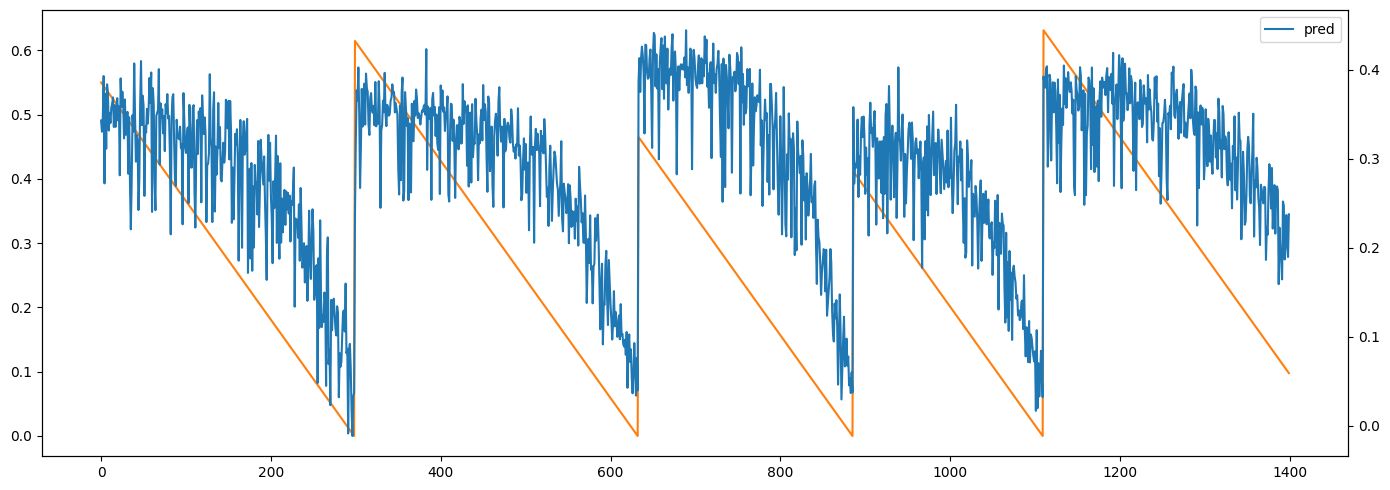

In [130]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [131]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0141
Deviazione standard della MSE: 0.0012


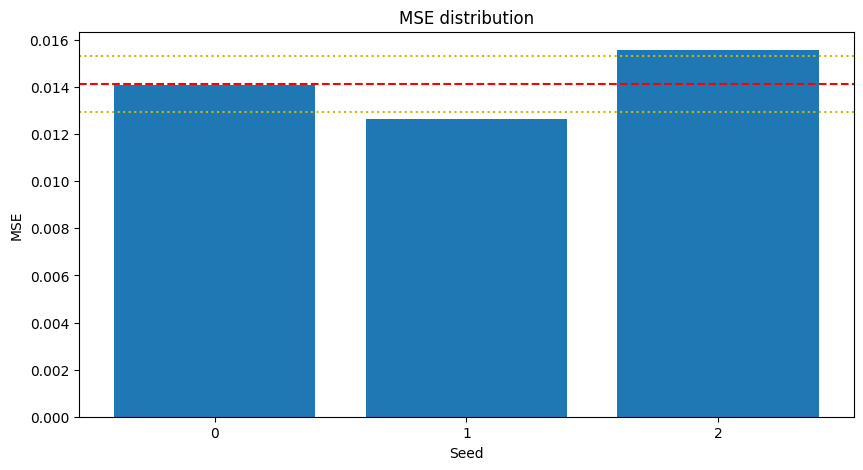

In [132]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

### Task 4: Knowledge injection by adding a new regularizer. We want to enforce the RUL being strictly positive

We think that adding a regularizer to enforce the RUL to be strictly positive will have a positive influence on model's performances with only unsupervised data. Indeed inferring **domain knowledge** will enhance the prediction qualiy of the regressor.
As a matter of fact we expect that the following model will achieve better results in comparison with the previous one (that considers only unsupervised data).

Tuning the hyperparameter *gamma* should have a great impact on the results obtained.

In [36]:
#usando unsupervised 100% e gamma = 0.1 -> Media della MSE: 0.0324, Deviazione standard della MSE: 0.0072

In [168]:
tru, ts = cst.split_machines(dt, 0, 0.75)

Num. machines: 186 (unsupervised), 63 (test)


In [169]:
print(f'Num. samples: {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 45385 (unsupervised), 15864 (test)


In [170]:
tru_s, ts_s, trmaxrul = cst.standardize(tru, ts, dt_in)

In [171]:
tru_st = cst.remove_rul(tru_s)

In [178]:
pred = []
for i in range(3):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    model = cst.CstPosRULRegressor(len(dt_in), alpha=0, beta=1.0, gamma=1.0, maxrul=trmaxrul, hidden=[32, 32])
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    model.compile(optimizer='Adam', run_eagerly=False)
    history = model.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(model.predict(ts_s[dt_in]).ravel())
    

Epoch 1/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0023 - mse: 0.0000e+00 - cst: 0.0015 - positivity_regularizer: 7.2494e-04
Epoch 2/5
1339/1339 [==============================] - 4s 3ms/step - loss: 4.6323e-04 - mse: 0.0000e+00 - cst: 4.6320e-04 - positivity_regularizer: 3.7648e-08
Epoch 3/5
1339/1339 [==============================] - 3s 3ms/step - loss: 4.4171e-04 - mse: 0.0000e+00 - cst: 4.4171e-04 - positivity_regularizer: 0.0000e+00
Epoch 4/5
1339/1339 [==============================] - 4s 3ms/step - loss: 4.2238e-04 - mse: 0.0000e+00 - cst: 4.2238e-04 - positivity_regularizer: 0.0000e+00
Epoch 5/5
496/496 [==============================] - 0s 370us/step
Epoch 1/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0028 - mse: 0.0000e+00 - cst: 0.0028 - positivity_regularizer: 1.1897e-06
Epoch 2/5
1339/1339 [==============================] - 3s 3ms/step - loss: 4.6409e-04 - mse: 0.0000e+00 - cst: 4.6405e-04 - positivity_regularizer: 3.4675

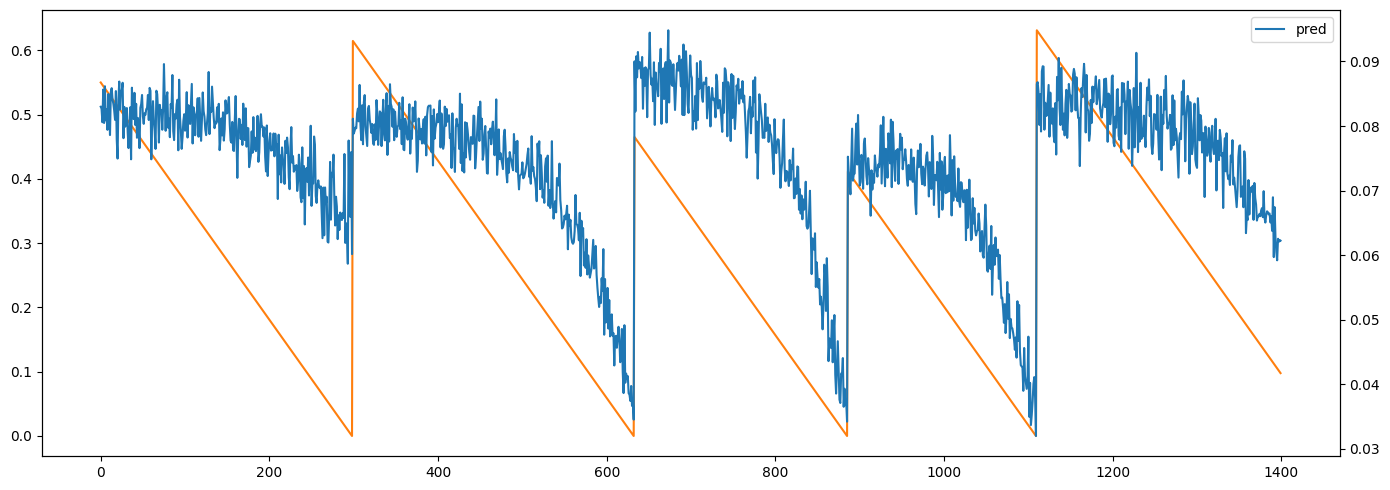

In [179]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [180]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0495
Deviazione standard della MSE: 0.0059


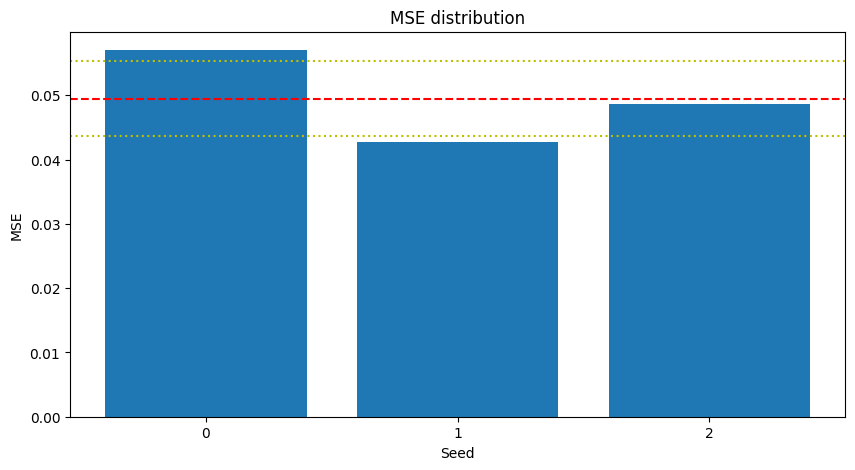

In [182]:
cst.plot_results(mse_seeds, mse_mean, mse_std)

**Results**

### Task 5: Lagrangian for dinamic weight of the loss function

In fact, the fairness constraint and accuracy are conflicting goals
Satisfying the constraint has in this case higher priority

Introducing a Lagrange multiplier can be considered as a weight that dynamically adjusts the importance of the regularization term, allowing the model to learn its optimal value during training.

In [209]:
tru, ts = cst.split_machines(dt, 0, 0.75)

Num. machines: 186 (unsupervised), 63 (test)


In [210]:
print(f'Num. samples: {len(tru)} (unsupervised), {len(ts)} (test)')

Num. samples: 45385 (unsupervised), 15864 (test)


In [211]:
tru_s, ts_s, trmaxrul = cst.standardize(tru, ts, dt_in)

In [212]:
tru_st = cst.remove_rul(tru_s)

In [224]:
pred = []
for i in range(3):
    np.random.seed(i)
    tf.random.set_seed(i)
    random.seed(i)
    nn = cst.CstRULRegressorWithLagrangian(input_shape=len(dt_in), alpha=0, beta=1, maxrul=trmaxrul, hidden=[32, 32]) 
    batch_gen = cst.CstBatchGenerator(tru_st, dt_in, batch_size=32, seed=i, validation_split=0.2)
    cb = [callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
    nn.compile(optimizer='Adam', run_eagerly=False)
    history = nn.fit(batch_gen, epochs=5, verbose=1, callbacks=cb)
    pred.append(nn.predict(ts_s[dt_in]).ravel())

Epoch 1/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0073 - mse: 0.0000e+00 - cst: 0.0037
Epoch 2/5
1339/1339 [==============================] - 3s 3ms/step - loss: 8.5300e-04 - mse: 0.0000e+00 - cst: 4.4734e-04
Epoch 3/5
1339/1339 [==============================] - 3s 3ms/step - loss: 7.4184e-04 - mse: 0.0000e+00 - cst: 4.4761e-04
Epoch 4/5
1339/1339 [==============================] - 3s 3ms/step - loss: 4.5771e-04 - mse: 0.0000e+00 - cst: 4.2250e-04
Epoch 5/5
496/496 [==============================] - 0s 529us/step
Epoch 1/5
1339/1339 [==============================] - 4s 3ms/step - loss: 0.0038 - mse: 0.0000e+00 - cst: 0.0019
Epoch 2/5
1339/1339 [==============================] - 4s 3ms/step - loss: 9.1629e-04 - mse: 0.0000e+00 - cst: 5.1005e-04
Epoch 3/5
1339/1339 [==============================] - 3s 3ms/step - loss: 5.6999e-04 - mse: 0.0000e+00 - cst: 4.5134e-04
Epoch 4/5
1339/1339 [==============================] - 4s 3ms/step - loss: 4.5096e-04 - mse: 0.

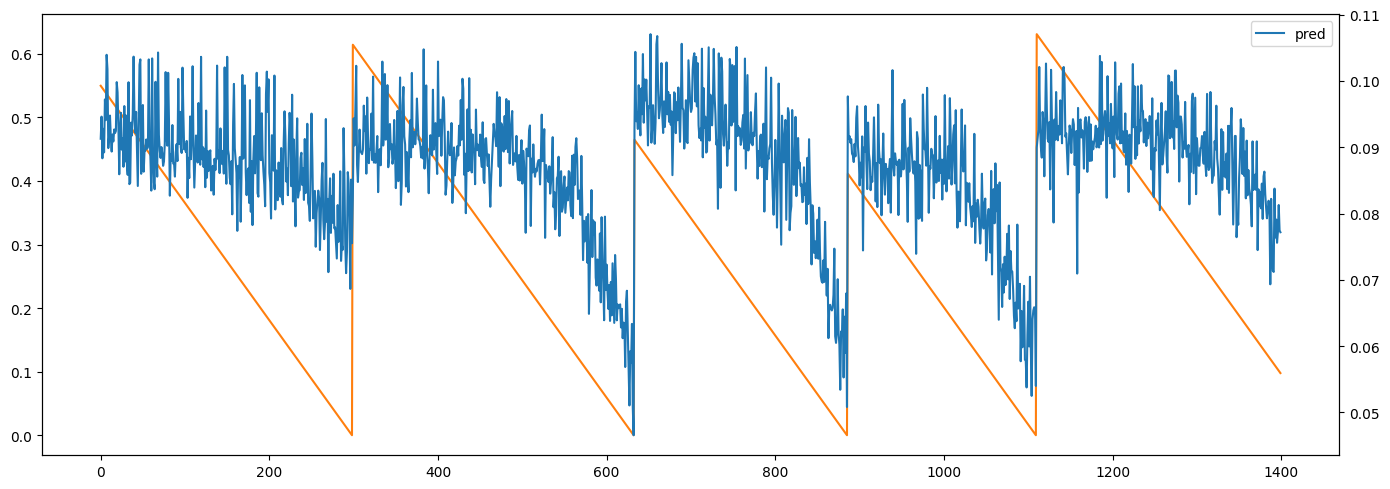

In [225]:
ts_pred = pred[0]
cst.plot_rul(ts_pred[:stop], ts_s["rul"].iloc[:stop], same_scale=False, figsize=figsize)

In [226]:
mse_seeds, mse_mean, mse_std = cst.evaluation(pred, ts_s)

Media della MSE: 0.0840
Deviazione standard della MSE: 0.0218


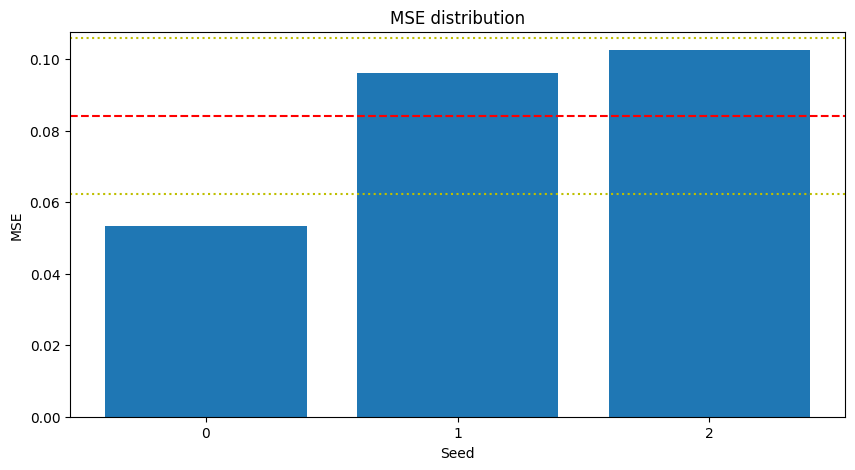

In [227]:
cst.plot_results(mse_seeds, mse_mean, mse_std)